#### This notebook aims at create a CNN based land cover classifier that label the raster images in west Africa.

In [10]:
import glob
import os
from os.path import join
from natsort import natsorted
import rasterio
import imageio.v2 as imageio
import numpy as np
from tqdm import tqdm

import time
import copy

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader, random_split

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


PyTorch Version:  1.14.0.dev20221103+cu117
Torchvision Version:  0.15.0.dev20221103+cu117


In [11]:
# create color map to display the landcover
colors_list = ['yellow', 'pink', 'teal', 'gray', 'red', 'white', 'aqua', 'orange', 'darkblue']
cmap = mpl.colors.ListedColormap(colors_list)
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 256]
norm = colors.BoundaryNorm(bounds, cmap.N)


In [12]:
label_path = '/mnt/ceph/boyuz/Builiding_Landscaping/land_conver_segmentation/partial_label/data/Bing_Circle_Labels'

raster_path = '/mnt/ceph/boyuz/Builiding_Landscaping/land_conver_segmentation/partial_label/data/Bing_Raster_Images'

tile_path = '/mnt/ceph/boyuz/Builiding_Landscaping/land_conver_segmentation/partial_label/data/Bing_Circle_Tiles'

# preprocessing parameters
generate_tile_label = False
tile_size = 64
step = 24


feature_dict = {'0': 'bare', '1':'grass', '2':'tree','3':'burn', '4':'rice', '5':'cloud', '6':'water', '7':'mound'}
classes = tuple(feature_dict.keys())

batch_size = 256
num_classes  = len(classes)
num_epochs = 30


In [13]:
def split2tiles(image, label, tile_size=64, step=16):
    
    x_range = np.arange(0, label.shape[0]-tile_size, step)
    y_range = np.arange(0, label.shape[1]-tile_size, step)

    tile_list, lbl_list = [], []
    for x in x_range:
        for y in y_range:
            tile_lbl = label[x + tile_size // 2, y + tile_size // 2]
            if tile_lbl != 255:
                tile_list.append(image[x:x+tile_size, y:y+tile_size, :])
                lbl_list.append(tile_lbl)

    return np.array(tile_list), np.array(lbl_list)


In [14]:
if generate_tile_label: # generate data, will take about 10m
    label_list = glob.glob(join(label_path, '*.tif'))
    raster_list = [x.replace('Bing_Circle_Labels', 'Bing_Raster_Images') for x in label_list]
    for raster, label in tqdm(zip(raster_list, label_list)):
        site = raster.split(os.sep)[-1][:-4]
        print(site)
        
        img = imageio.imread(raster)[:,:,0:3]
        lbl = imageio.imread(label)
        tiles, labels = split2tiles(img, lbl, tile_size=tile_size, step=step)

        np.save(join(tile_path, site + '_img'), tiles)
        np.save(join(tile_path, site + '_lbl'), labels)


In [15]:
# get all data
tile_file_list = natsorted(glob.glob(join(tile_path, '*_img.npy')))
label_file_list = natsorted(glob.glob(join(tile_path, '*_lbl.npy')))

all_tiles, all_labels = [], []
for idx, (tile_file, label_file) in enumerate(zip(tile_file_list, label_file_list)):
    site_tile = tile_file.split(os.sep)[-1][:-8]
    site_label = label_file.split(os.sep)[-1][:-8]
    assert site_tile == site_label
    tiles = np.load(tile_file)
    labels = np.load(label_file)
    if idx == 0:
        all_tiles, all_labels = tiles, labels
    else:
        all_tiles = np.concatenate((all_tiles, tiles), axis=0)
        all_labels = np.concatenate((all_labels, labels), axis=0)

print('Got {} samples'.format(all_labels.shape[0]))

# split into train/val/test
# switch axis
all_tiles = np.moveaxis(all_tiles, -1, 1)

# create dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

tensor_x, tensor_y = torch.Tensor(all_tiles), torch.Tensor(all_labels)
print(tensor_x.shape, tensor_y.shape)
full_dataset = TensorDataset(tensor_x, tensor_y)
train_set, test_set = random_split(full_dataset, [int(0.9*len(full_dataset)), len(full_dataset)-int(0.9*len(full_dataset))])
train_set, val_set = random_split(train_set, [int(0.9*len(train_set)), len(train_set)-int(0.9*len(train_set))])

dataset_sizes = {'train': len(train_set), 'val': len(val_set)}
# create dataloaders
train_val_loaders = {'train': DataLoader(train_set, batch_size=batch_size, shuffle=True),
                        'val': DataLoader(val_set, batch_size=batch_size, shuffle=False)}


test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Got 326127 samples
torch.Size([326127, 3, 64, 64]) torch.Size([326127])


In [16]:
input, target = next(iter(test_loader))
target.dtype

torch.float32

In [17]:
# define model
model = models.resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device=device);


In [8]:
def train_model(model, criterion, optimizer, scheduler, dataloaders= train_val_loaders, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            counter = 0
            
            for inputs, labels in dataloaders[phase]:
                
                counter += 1
                if counter % 500 == 0 and phase == 'train':
                    print(f'Training progress, {counter}th of {len(dataloaders[phase])}')
                if counter % 50 == 0 and phase == 'val':
                    print(f'Validation progres, {counter}th of {len(dataloaders[phase])}')

                inputs = inputs.to(device)
                labels = labels.type(torch.LongTensor)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
# set parameters
# create weights
_, counts = np.unique(all_labels, return_counts=True)
weights = torch.tensor(counts/sum(counts), dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [10]:
# train
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders=train_val_loaders, num_epochs=num_epochs)

Epoch 0/29
----------
Training progress, 500th of 1032
Training progress, 1000th of 1032
train Loss: 0.2394 Acc: 0.7977
Validation progres, 50th of 115
Validation progres, 100th of 115
val Loss: 0.1142 Acc: 0.8641

Epoch 1/29
----------
Training progress, 500th of 1032
Training progress, 1000th of 1032
train Loss: 0.1119 Acc: 0.8643
Validation progres, 50th of 115
Validation progres, 100th of 115
val Loss: 0.0897 Acc: 0.8806

Epoch 2/29
----------
Training progress, 500th of 1032
Training progress, 1000th of 1032
train Loss: 0.0927 Acc: 0.8806
Validation progres, 50th of 115
Validation progres, 100th of 115
val Loss: 0.0798 Acc: 0.8890

Epoch 3/29
----------
Training progress, 500th of 1032
Training progress, 1000th of 1032
train Loss: 0.0809 Acc: 0.8941
Validation progres, 50th of 115
Validation progres, 100th of 115
val Loss: 0.0753 Acc: 0.8953

Epoch 4/29
----------
Training progress, 500th of 1032
Training progress, 1000th of 1032
train Loss: 0.0746 Acc: 0.9021
Validation progres, 

In [11]:
torch.save(model_ft, 'cnn_model_' + str(5) + '_epoch_' + str(30) + '.pt')

Testing the performance

In [8]:
def split2tiles_test(image, tile_size=64, step=1):
    
    x_range = np.arange(0, image.shape[0]-tile_size, step)
    y_range = np.arange(0, image.shape[1]-tile_size, step)

    tile_list = []
    for x in x_range:
        for y in y_range:
            tile_list.append(image[x:x+tile_size, y:y+tile_size, :])

    return np.array(tile_list), len(x_range), len(y_range)

In [9]:
# label an image with it
img_path = '/mnt/ceph/boyuz/Builiding_Landscaping/land_conver_segmentation/partial_label/data/Cropped_Image_Datasets/HR_Bing_Circle_Labels_1024_step_1024/images/Badala50.png'

test_img = imageio.imread(img_path)
tile_list, num_x, num_y = split2tiles_test(test_img)
tile_list = np.moveaxis(tile_list, -1, 1)

predictions = []
counter = 0
batch_size_test = 512
for i in range(0, len(tile_list), batch_size_test):
    if i + batch_size_test < len(tile_list) - 1:
        input = torch.tensor(tile_list[i:i+batch_size_test], dtype=torch.float)
    else:
        input = torch.tensor(tile_list[i:], dtype=torch.float)
    
    output = model_ft(input.to(device))
    _, preds = torch.max(output, 1)
    predictions = predictions + list(preds.detach().cpu().numpy())
    counter += 1
    if counter % 1024 == 0:
        print(f'{counter}th of {len(range(0, len(tile_list), batch_size_test))} total')

mask_pred = np.reshape(predictions, (num_x, num_y))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(test_img)
ax2.imshow(mask_pred, cmap = cmap, norm = norm, interpolation = 'none')

NameError: name 'model_ft' is not defined

In [47]:
# predictions = []
# counter = 0
# batch_size_test = 256
# for i in range(0, len(tile_list), batch_size_test):
#     if i + batch_size_test < len(tile_list) - 1:
#         input = torch.tensor(tile_list[i:i+batch_size_test], dtype=torch.float)
#     else:
#         input = torch.tensor(tile_list[i:], dtype=torch.float)
    
#     output = model_ft(input.to(device))
#     _, preds = torch.max(output, 1)
#     predictions = predictions + list(preds.detach().cpu().numpy())
#     counter += 1
#     if counter % 1024 == 0:
#         print(f'{counter}th of {len(range(0, len(tile_list), batch_size_test))} total')


2000th of 4115 total
4000th of 4115 total


In [57]:
_, counts = np.unique(all_labels, return_counts=True)

In [61]:
sum(counts/sum(counts) * [0.957, 0.738, 0.954, 0.899, 0.605, 1, 0.95, 0.941])


0.9066208194966991

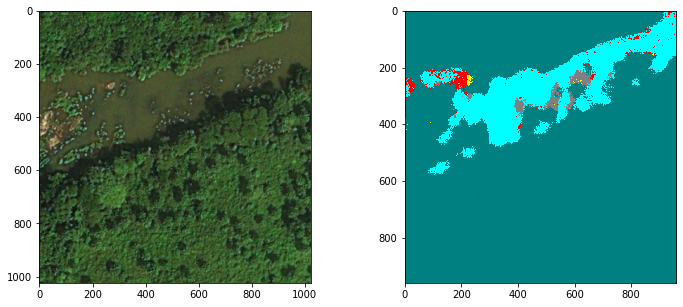